# 4.4 Evaluating models


In the last section we created a very simple model linking the binarised self reported health with the deprivation index controlled by age for the UK. We emphasised understanding the model and developed intuition of what the model learns, but a modelling task is not complete without evaluation. Evaluation examines how well the model has learned the data and is able generalise it in unseen data.

One of the evaluation tools available to us are **goodness-of-fit** metrics. These metrics (some of which are described below) summarise the discrepancy between observed values from the data used for fitting and the values expected under the estimated parameters of the model. 

````{margin}
```{admonition} Many metrics for different purposes
Goodness of fit metrics depend of the kind of model you are fitting, e.g. in regression you tend to look at the *Mean Square Error*, *Root Mean Squared Error*, *Coefficient of Determination*, residual plots, etc. (although all these metrics have to be interpreted with the full knowdlege of the context of the data and model,  you can find more about these metrics in [here](https://medium.com/microsoftazure/how-to-better-evaluate-the-goodness-of-fit-of-regressions-990dbf1c0091)). 
```
````

The **goodness-of-fit** metrics alone are not enough for a full evaluation of the model. A fit can learn perfectly the data but can be **overfitted**, meaning that they have learned the pecularities (noise) of the dataset and will not make good predictions on future unseen samples (we touched on overfitting in the section _Fitting a Model_). Hence, part of model evaluation is to estimate the generalization accuracy of a model on unseen/out-of-sample data by using a **test set** (i.e data not seen by the model). 

In this section we will build on the modelling steps done in section 4.3 and perform model evaluation.  In this example we are focusing on logistic regression, however we will try to make the concepts and ideas generalisable to other models. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn import metrics
from matplotlib import pyplot
from scipy import stats

plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_style("white")

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data processing

**Note**: *We aim that each section can function as a stand-alone material, therefore we repeate the data processing steps in Sections 3.5, 4.3 and now here. Feel free to skip to the next section.*

 We can access the data by downloading the csv option from here. Create a folder data in the same root as this notebook. Copy the folder UKDA-7724-csv and its contents there.

In [2]:
datafolder = 'data/UKDA-7724-csv/'
df11 = pd.read_csv(datafolder + 'csv/eqls_2011.csv')
df_map = pd.read_csv(datafolder + 'mrdoc/excel/eqls_api_map.csv', encoding='latin1')

In [3]:
# we are only interested in the UK for this example.
df11 = df11.query('Y11_Country == 27')

var_map = {"Y11_Q42": "SRH",
           'Y11_Deprindex': 'DeprIndex',
           "Y11_RuralUrban": "RuralUrban",
           "Y11_Accommproblems": 'AccomProblems',
           "Y11_HHsize": "HouseholdSize",
           "Y11_Q32": "Children",
           "Y11_ISCEDsimple":"ISCED",
           "Y11_Education": "Education",
           "Y11_SocExIndex":"SocialExclusionIndex",
           "Y11_MWIndex": "MentalWellbeingIndex",
           "Y11_Agecategory":"AgeCategory",
           "Y11_HH2a":"Gender",
           "Y11_Q31":"MaritalStatus",
           "Y11_Country":"Country"
}

df11.rename(columns=var_map, inplace=True)
df11_set = df11[var_map.values()]

We drop rows with missing data (**warning**: this shoudn't be done lightly without having explored the missingness of the data, here we are doing for simplicity and to focus on the modelling).

In [4]:
df11_model = df11_set.dropna() 

Finally, we dichotomise the `SRH` variable.

In [5]:
# dichotomoise SRH
df11_model['SRH_binary'] = df11_model.SRH.apply(lambda x: 1 if float(x) <= 3 else 0)

/anaconda3/envs/rds-course/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Model 1: Age and Deprivation index.

Let's start evaluating the performance of a simple model described in _Section 4.3_ where we model `SRH` as a function of Age and Deprivation. In that section we use our complete UK dataset to fit the model as an ilustrative example, however this is not best practice at the time of building and evaluating models.

It’s not recommended to use the data we used to build the model to evaluate it, the best approach is to partition your dataset into a **training** sample used to fit you model, and a **holdout** sample for evaluation. The purpose of this is to obtain an unbiased estimate of learning performance. 

Depending on your model you might need a **training**, **validation** and **testing** set (e.g a validation set can be useful when you have to tune model hyperparameters). However, for this example we will use a simple **train**/**test** split following a 70/30 rule (for more in depth discussion of what is a "good test size" check-out this [blog post](https://www.r-bloggers.com/2021/01/what-is-a-good-test-set-size-2/)).

In [6]:
# test train split using scikit learn, defining random state for reproducibility
trainX_model1, testX_model1, trainy_model1, testy_model1 = train_test_split(df11_model[['AgeCategory','DeprIndex']], df11_model.SRH_binary.values, test_size=0.3, random_state=2)

````{margin}
```{admonition} Cross-Validation
In this example we will use a fixed train/test split, but this has its dangers — what if the split we make isn’t random? (e.g data could be ordered in a non random manner, or we could be unlucky in our split to have a non-representative sample). A solution for this is to use **cross-validation**. This method is very similar to train/test split, but it’s applied to more subsets. Meaning, the dataset is split into *k* subsets (or folds), and the model is trainned on k-1 one of those subsets. The remaining subset is used to test the model. This is done iteratively *k* times and then the score metrics obtained on each of the folds are averaged into a a summarized performance of the model. More information on **cross-validation** can be found [here](https://scikit-learn.org/stable/modules/cross_validation.html).
```
````

Now, let's fit our model on our training set.

In [7]:
trainX_const_model1 = sm.add_constant(trainX_model1) #add constant for intercept
logit_model_model1 = sm.Logit(trainy_model1, trainX_const_model1) #Create model instance
result_model1 = logit_model_model1.fit() #Fit model

Optimization terminated successfully.
         Current function value: 0.325243
         Iterations 7


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In the output, ‘Iterations‘ refer to the number of times the model iterates over the data to optimize the model.

## Validating the fit
Let's explore the output of the fit. The summary table below gives us a descriptive summary about the results.  

In [8]:
print (result_model1.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1392
Method:                           MLE   Df Model:                            2
Date:                Fri, 29 Oct 2021   Pseudo R-squ.:                 0.08318
Time:                        16:31:54   Log-Likelihood:                -453.71
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 1.323e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.0847      0.349     11.692      0.000       3.400       4.769
AgeCategory    -0.4030      0.081     -4.950      0.000      -0.563      -0.243
DeprIndex      -0.3615      0.043     -8.317    

In _Section 4.3_ we discussed the interpretation of the coefficients, standard errors and significance parameters. In this section we'll explore the output related to the **goodness-of-fit**.

- **Method**:  Maximum Likelihood Estimation (MLE) is a probabilistic framework for estimating the parameters of an assumed probability distribution, given some observed data. MLE involves maximizing a likelihood function in order to find the probability distribution and parameters that best explain the observed data.
- **No. Observations**: Number of observations on our training set.
- **Df. Residuals**:  This is the Degrees of Freedom in the model. This is calculated in the form of `number of observations` - `number of predictors` - 1.
- **Df. Model**: Degrees of Freedom of our model, which is basically the number of predictors used in the model (or number of coefficients to be fitted).
- **Log-Likelihood**: the natural logarithm of the Maximum Likelihood Estimation (MLE) function given the estimated parameters. The log likelihood function in maximum likelihood estimations is usually computationally simpler, and the log-likelihood maximum is the same as the maximum likelihood.
- **LL-Null**: the value of log-likelihood of the model when no independent variable is included (only an intercept is included).
- **Pseudo R-squ.**: It is the ratio of the log-likelihood of the null model to that of the full model (this can function as a substitute for the R-squared value in Least Squares linear regression).
- **LLR p-value**: A small p-value you can reject the null hypothesis that the model based on the intercept (all coefficients = 0) is better than the full model, again this uses the ratio of the log-likelihood of the null model to that of the full model.

For the remainder of this section we will be using the **log-likelihood** values as a way to compare how a model improves when adding a new predictor. 

## Evaluation through prediction on new data
  
Now we test our model using our test dataset. 

As we learned in M4.2, logistic regression works by first obtaining the prediction of the model as a probability, then binarising the predicted probability using a threshold value. Scores above the threshold value will be classified as positive, those below as negative. For now the threshold value of the probability is $prob(x)>0.5$.

In [9]:
# performing predictions on the test datdaset
yhat = result_model1.predict(sm.add_constant(testX_model1))
pred_y_model1 = list(map(round, yhat))
 
# comparing first 10 original and predicted values of y
print('Actual values', list(testy_model1)[:10])
print('Predictions :', pred_y_model1[:10])

Actual values [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predictions : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In the cell above we are just printing the first 10 observations of our dataset. In order to summarise the the accuracy of the predictions from our model we can use a confusion matrix. This maps the predicted and actual values into a matrix and can give us an idea of what the classification model is getting right and what types of errors it is making.

From a confusion matrix we can obtain the True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives (FN) and calculate the following metrics:


- $Accuracy = \frac{TP  + TN}{TP + FP + TN + FN}$


- $Precision = 
     \frac{TP}{TP + FP}$
     
     
- $Recall = 
      \frac{TP}{TP + FN}$
      
    

Accuracy: 0.8931552587646077
Precision: 0.8961474036850922
Recall: 0.9962756052141527


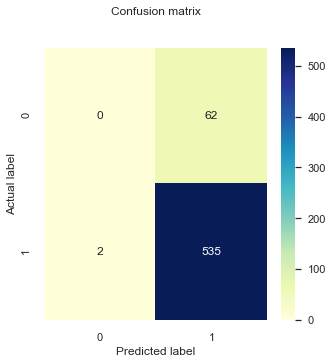

In [10]:
# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)

def plt_cnf_mat(cnf_matrix, ax, class_names=[0,1]):
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1)) # what is recall? 

You can see here that no negative values get predicted and the overwelming majority of responses are true positives. Furthermore, the accuracy, precision and recall score > 89%, this is happening due to our dataset being highly imbalanced and that the minority class are labeled as negative (0).

A better evaluation would be to estimate these metrics as a function of the minority class in the following way:



In [11]:
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Accuracy:",metrics.accuracy_score(testy_model1_minority, pred_y_model1_minority))
print("Precision:",metrics.precision_score(testy_model1_minority, pred_y_model1_minority))
print("Recall:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority)) 

Accuracy: 0.8931552587646077
Precision: 0.0
Recall: 0.0


The results above are not a surprise. In 4.3 we saw that the model considers deprivation as a continous variable and observed that the cutoff point of the model (this is the value where the model starts predicive negative labels) for the deprivation predictor was around 7, which is larger than the existing range for this variable. Nonetheless, in our examination of the model in 4.3 we observed that the model was indeed learning from the data and reproducing it, and after examining the **log-likelihoods** of the fit summary above we can conclude that the model is indeed better than a null model where the predictors do not add any information.  

This means that the classification matrix, which show that our model is unable to ever predict the negative labels existing in the dataset might not be the best tool to evaluate the model in this scenario. Particularly because it shows a snapshot of the results being mapped from a predicted probability using a threshold of $p(x)> 0.5$.


### Investigating threshold values

Let's go back to our probability and investigate the predicted values given by the model for our two labels:

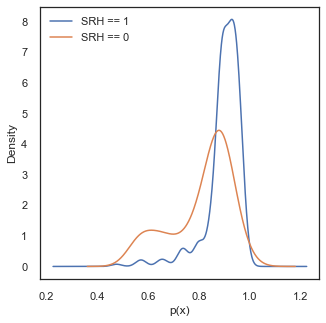

In [12]:
# link the prediction to the label values
df_labels = pd.DataFrame({'prediction': yhat,
     'label': testy_model1})

fig, ax = plt.subplots(1,1, figsize = (5,5))
df_labels[df_labels['label']==1]['prediction'].plot.kde(label='SRH == 1')
df_labels[df_labels['label']==0]['prediction'].plot.kde(label='SRH == 0')
pyplot.xlabel('p(x)')
pyplot.legend()



Ideally, in this density plot we would observe the probability scores between two classes to be separated, with the score of the cases where `SRH==0` on the low probability values and the score of cases with `SRH==1` to be on the the high values. However, in the current case both distributions are slight skewed to the high probability values. The reason for this is because our dataset is highly imbalanced and only consists of 10 percent of cases where `SRH ==0`. Thus the predicted probabilities sort of gets pulled towards a higher values because of the majority of the data being positive cases.

In [13]:
print ('Mean value for SRH ==1,', round(df_labels[df_labels['label']==1]['prediction'].mean(),3))
print ('Mean value for SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].mean(),3))
print ('Percentage of cases with SRH ==0,', round(df_labels[df_labels['label']==0]['prediction'].count()/df_labels.shape[0],3))

Mean value for SRH ==1, 0.898
Mean value for SRH ==0, 0.812
Percentage of cases with SRH ==0, 0.104


Despite all this, in the density figures above we can observe a separation in the predicted scores, and the performance of the model could be improve by selecting a better threshold value of the probability use to classify each case. This should be done by making a balance between the rate of False Positives and False Negatives. For this we can use other tools avalaible, such as **ROC curves**.

### What Are ROC Curves?

A receiver operating characteristic curve, or ROC curve, is a figure that illustrates the performance of a binary classifier as its discrimination threshold is varied.

Let's examine how the ROC courve looks for our model, and how it compares to a dummy classifier with no skill in classifying our data. 

In [14]:
# function from https://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python
def plot_roc(labels, predictions, positive_label, thresholds_every=10, title='', c='darkorange'):
    # fp: false positive rates. tp: true positive rates
    fp, tp, thresholds = roc_curve(labels, predictions, pos_label=positive_label)
    roc_auc = roc_auc_score(labels, predictions)

    plt.plot(fp, tp, label=title+' ROC curve (area = %0.2f)' % roc_auc, linewidth=2, color=c)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2)
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.title('ROC curve (numbers are threshold values)')
    plt.legend(loc="lower right")
    plt.grid(True)

    # plot some thresholds
    thresholdsLength = len(thresholds)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_three_decimals = str(thresholds[i])[:4]
        plt.text(fp[i] - 0.05, tp[i] + 0.015, threshold_value_with_max_three_decimals, fontdict={'size': 10},color=c)

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


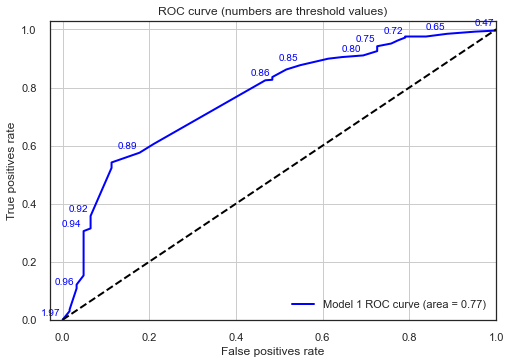

In [15]:
lr_probs_model1 = result_model1.predict(sm.add_constant(testX_model1))

plot_roc(testy_model1, lr_probs_model1, positive_label=1, thresholds_every=3, title="Model 1",c='blue')

The AUC values printed above reflects the area under the ROC curve and provides a measure of how discriminant the model is between the two classes.  [In general, an AUC of 0.5 means no discrimination, 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding](https://www.sciencedirect.com/science/article/pii/S1556086415306043#:~:text=AREA%20UNDER%20THE%20ROC%20CURVE,-AUC%20is%20an&text=In%20general%2C%20an%20AUC%20of,than%200.9%20is%20considered%20outstanding.).

A value of 0.5 for AUC indicates that the ROC curve will fall on the diagonal (i.e., 45-degree line) and hence suggests that the diagnostic test has no discriminatory ability. 

Here we confirm again that we our model has learned something and performs better that a "unskilled" dummy classifier. Now, we can use the ROC values to obtain an optimal threshold value. One of the commonly used method for this is the [Youden index method](https://en.wikipedia.org/wiki/Youden%27s_J_statistic). In this method the optimal threshold values is the one that maximises the Youden function which is the difference between true positive rate and false positive rate over all possible threshold values.

We wrote a small implementation of this method for this example:

In [16]:
# function inpired by https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def find_optimal_threshold(target, predicted):
    """ Find the optimal probability threshold for a classification model.
    Parameters
    ----------
    target : Matrix with label data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    a float, with optimal cutoff value
        
    """
    fpr, tpr, thresholds = roc_curve(target, predicted)
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

threshold = find_optimal_threshold(df_labels['label'], df_labels['prediction'])
print (round(threshold,4))

0.8997


This is quite far from the 0.5 value we orginially had! Let's see how our classification matrix does now using this new threshold.

**Note**: In this case we have decided that the optimal threshold value is the one that, which which maximises the True Positive rate and minimizes the False Positive rate. However, the definition of **optimal** really depends of the research question or the task we are to solve. An alternative would be to give more importance in accurately classifying our `SRH=0` class and try to maximise the True Negative Rate. 

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Accuracy: 0.5692821368948247

Precision: 0.9761092150170648
Recall: 0.5325884543761639

Precision Minority Label: 0.17973856209150327
Recall Minority Label: 0.8870967741935484


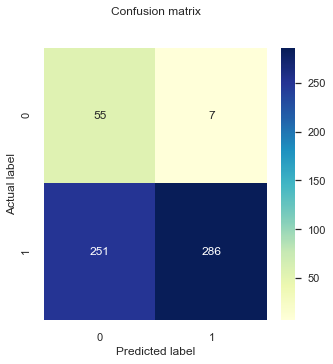

In [17]:


# performing predictions on the test datdaset
yhat = result_model1.predict(sm.add_constant(testX_model1))
pred_y_model1 =  [1 if x > threshold else 0 for x in yhat]


# confusion matrix using sklearn
cnf_matrix = metrics.confusion_matrix(testy_model1,pred_y_model1)
    
fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix, ax)


print("Accuracy:",metrics.accuracy_score(testy_model1, pred_y_model1))

print ()
print("Precision:",metrics.precision_score(testy_model1, pred_y_model1))
print("Recall:",metrics.recall_score(testy_model1, pred_y_model1)) # what is recall? 

print ()
testy_model1_minority = abs(testy_model1 - 1)
pred_y_model1_minority = abs(np.array(pred_y_model1) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model1_minority, pred_y_model1_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model1_minority, pred_y_model1_minority)) 

Using this new threshold values improves significantly the recall for our minority label (`SRH==0`), but a large expense of the classification performance of the mayority label (`SRH==1`). However, a model that puts all instances in one class is not of good use for us, so this is an improvement. Furthermore, depending of our research question and the ultimate goal of the model we might want to maximise the recall of the minority label, even if this means increasing the amount of false negatives we observe. For example, it might be more important to identify people that are likely to report poor health than the ones with good health.

In any case, we must remember that up to know we are using a very simple model, only using deprivation as a predictor and controling for age. Adding more predictors to the model can improve its performance. We'll explore that next.

## Model 2: Model 1 + Education, No. of Children and Accomodation Problems

Let's increase the complexity to our model by adding more predictors representing socio-economic factors. In this case we'll add information about education (levels of education completed), number of children and number of problems with accommodation reported by the respondants. All these variables are ordered categorical variables that we assume to function as continous variables for this exercise.  

In [18]:
trainX_model2, testX_model2, trainy_model2, testy_model2 = train_test_split(df11_model[['AgeCategory','DeprIndex','ISCED','Children',"AccomProblems"]], df11_model.SRH_binary.values, test_size=0.3, random_state=2)

trainX_const_model2 = sm.add_constant(trainX_model2) #add constant for intercept
logit_model2 = sm.Logit(trainy_model2, trainX_const_model2) #Create model instance
result_model2 = logit_model2.fit() #Fit model

Optimization terminated successfully.
         Current function value: 0.317076
         Iterations 7


/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
print (result_model2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1389
Method:                           MLE   Df Model:                            5
Date:                Fri, 29 Oct 2021   Pseudo R-squ.:                  0.1062
Time:                        16:31:55   Log-Likelihood:                -442.32
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 4.395e-21
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.2864      0.496      6.620      0.000       2.313       4.259
AgeCategory      -0.3592      0.088     -4.092      0.000      -0.531      -0.187
DeprIndex        -0.2929      0.046     

If we compare these fit results to the ones from **Model 1** we observe the following:

- The coefficient for *DeprIndex* has become less negative. This could mean that the new variables that we have added to the model have taken some of the weight that the deprivation index and age category carried. This is not surprising given that some of these variables are expected to be linked to deprivation (e.g *AccomProblems* and *ISCED*).  


- The coefficient for *AgeCategory* has also becomed less negative, but within the margin of its standard error. 


- Now, if we look at the parameters of *goodness-of-fit* we can observe that the fit has improved slighly, with a less negative log-likelihood and slighly larger pseudo R-squ. However, if we compare the increase of log-likelihood of adding these new variables with respect to the values of a null model, the improvement is modest (11 units of log likelihood of **Model 2** vs **Model 1** against 41 units for **Model 1** vs **Null model**). Take this into consideration, we could suspect that the new variables barely increase the discrimination power of our model. Lets take a look but evaluating it on the test set.

### Comparing predicted values 

Same as we did in the previous seccion, let's compare the predicted probability values of an event being classified as `SRH=1` or `SRH=0`. Let's do this but running the model on the test set and comparing the distributions.

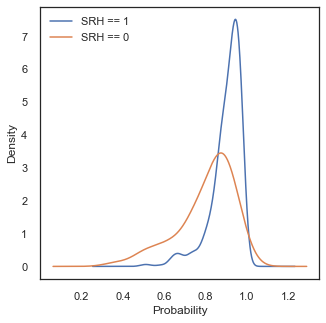

In [20]:
# link the prediction to the label values
yhat_model2 = result_model2.predict(sm.add_constant(testX_model2))
df_labels = pd.DataFrame({'prediction': yhat_model2,
     'label': testy_model2})

fig, ax = plt.subplots(1,1, figsize = (5,5))
df_labels[df_labels['label']==1]['prediction'].plot.kde(label='SRH == 1')
df_labels[df_labels['label']==0]['prediction'].plot.kde(label='SRH == 0')
pyplot.xlabel('Probability')
pyplot.legend()

The shape of the probability distributions do not look too different to what we observed in **Model 1** (maybe the tails for class `SHR=0` are longer) and again, we can observe that using the default threshold value around 0.5 will not be optimal in this case and a higher value should be chosen.

**Note**: Probability values of larger than one in this case are a product of using kernel density estimation for our visualisation. We choose this method because we want to compare shapes of distributions, however we must have in mind that it can create the impresion that there is data in ranges where there is not.

In [21]:
threshold_model2 = find_optimal_threshold(testy_model2, yhat_model2)
print ('Probability threshold cut',round(threshold_model2,4))
print()

Probability threshold cut 0.8662



### ROC curves
The probability threshold value is slighly lower than for model **Model 1**, but not significantly, given that the predicted distributions are quite similar.

Now, let's take a look at our ROC curves and AUC values and compare them to **Model 1**.

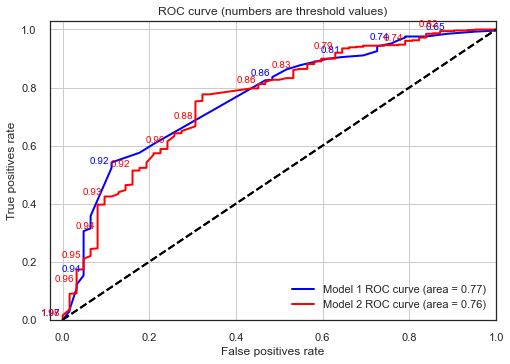

In [22]:
plot_roc(testy_model1, lr_probs_model1, positive_label=1, thresholds_every=5, title="Model 1",c='blue')
plot_roc(testy_model2 , yhat_model2, positive_label=1, thresholds_every=15, title="Model 2",c='red')

When comparing the above curves between the two models we can observe the following:

- The ROC curve for **Model 2** has a higher granularity of steps in which the True and False Positive rates are evaluated. This is because the sklearn function drops *suboptimal thresholds* which corresponds points on the ROC curve that will have the same TPR and FPR values that adjecent points. In the simpler model there might be configuration of predictor values to produce a high granularity curve.

- Despite the point above, AUC values and overall ROC shapes are pretty much the same.

This again confirms our theory that this new model doesn't contain much more discriminative power than **Model 1**, with the deprivation index carrying a good bulk of the information that these new variables such as education level and accommodation problems can add to the model.

### Classification matrix

Finally, let's take a look at our classification performance, using the optimal threshold value of classification for this model.

Accuracy: 0.7646076794657763

Precision: 0.9541284403669725
Recall: 0.7746741154562383

Precision Minority Label: 0.25766871165644173
Recall Minority Label: 0.6774193548387096


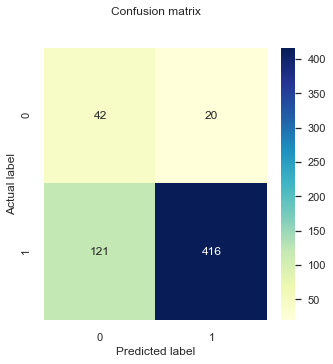

In [23]:
pred_y_model2 =  [1 if x > threshold_model2 else 0 for x in yhat_model2]

cnf_matrix_model2  = metrics.confusion_matrix(testy_model2,pred_y_model2)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model2 , ax)


print("Accuracy:",metrics.accuracy_score(testy_model2 , pred_y_model2 ))

print()
print("Precision:",metrics.precision_score(testy_model2 , pred_y_model2 ))
print("Recall:",metrics.recall_score(testy_model2 , pred_y_model2 )) 


print ()
testy_model2_minority = abs(testy_model2 - 1)
pred_y_model2_minority = abs(np.array(pred_y_model2) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model2_minority, pred_y_model2_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model2_minority, pred_y_model2_minority)) 

Comparing to **Model 1**:
    
- Our general accuracy improved (from 0.57 to 0.76!).
- The precision of our minority label increased (form 0.18 to 0.26), but the recall decreased (from 0.89 to 0.68).
- Recall for our majority label increased. 

It can be difficult to track the changes of all of these metrics but with such an imbalanced dataset **Accuracy** is not a good indicator. Particularly, in this case we might want to minimize False Negatives. For these cases, we can use the **F1-score**, which is is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the **Accuracy** metric.

$F1-score = 2*\frac{Precision*Recall}{Precision+ Recall}$

In [24]:
print ('Model 1:', metrics.f1_score(testy_model1 , pred_y_model1))
print ('Model 2:', metrics.f1_score(testy_model2 , pred_y_model2))

Model 1: 0.6891566265060242
Model 2: 0.8550873586844809


```{important}
Even if we didn't obseve much improvement in the separation of the predicted probability distribution or in the AUC values, the performance of our classification improves by the fact of using more predictors in our model that can allow for more complex descriptions of the data (i.e. our model has more degrees of freedom to fit a datapoint)!
```

## Model 3: Model 2 + Mental Wellbeing 

Now let's complicate the model even further, adding a variable related to mental wellbeing.

The mental wellbeing index correspond to the the World Health Organisation Well-Being Index and is a short self-reported 6 point scale measure referring to how the respondent felt over the previous two week. The questionare use only positively phrased questions and in the scale higher values mean better self reported mental health.

We decided to add this variable because they should be mostly orthogonal to the existing ones of **Model 2**, and a new dimension to the model that should improve its performance.

In [25]:
X = df11_model[['AgeCategory','DeprIndex','ISCED','Children',"MentalWellbeingIndex","AccomProblems"]]

y = df11_model.SRH_binary.values

trainX_model3, testX_model3, trainy_model3, testy_model3 = train_test_split(X, y, test_size=0.3, random_state=2)
trainX_const_model3 = sm.add_constant(trainX_model3) #add constant for intercept
logit_model3 = sm.Logit(trainy_model3, trainX_const_model3) #Create model instance
result_model3 = logit_model3.fit() #Fit model

print (result_model3.summary())

Optimization terminated successfully.
         Current function value: 0.275429
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1388
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Oct 2021   Pseudo R-squ.:                  0.2236
Time:                        16:31:56   Log-Likelihood:                -384.22
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 5.453e-45
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1605      0.569      2.041      0.041       0.046       2.275

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Let's repeate the excersice we did in the previous section and compare the fit results between **Model 2** and **Model 3**. We observe the following:

- The coefficient for *DeprIndex* again has become significantly less negative. This could mean that the mental wellbeing variables is sharing the weight that the deprivation index carried (it is not a surprise to think that people living in deprivation are also likely to have poor mental health).


- Now, if we look at the parameters of *goodness-of-fit* we can observe that the fit has improved significantly, with a less negative log-likelihood (58 units of log likelihood of **Model 3** vs **Model 2**) and larger pseudo R-squ (0.22 vs 0.11). In this case the improvement is comparable to the increase of log-likelihood of adding new variables in **Model 2** with respect to the values of a null model (58 units of log likelihood of **Model 3** vs **Model 2** against 52 units for **Model 2** vs **Null model**).

Take this into consideration, we could suspect that including the mental health will increase the discrimination power of our model. Let's see if this is the case by evaluating it on the test set.

## Comparing predicted values
Same as we did in the previous seccion, let's compare the predicted probability values of an event being classified as `SRH=1` or `SRH=0`. Let's do this but running the model on the test set and comparing the distributions.



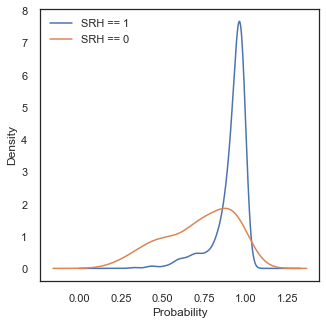

In [26]:
# link the prediction to the label values
yhat_model3 = result_model3.predict(sm.add_constant(testX_model3))
df_labels = pd.DataFrame({'prediction': yhat_model3,
     'label': testy_model3})

fig, ax = plt.subplots(1,1, figsize = (5,5))
df_labels[df_labels['label']==1]['prediction'].plot.kde(label='SRH == 1')
df_labels[df_labels['label']==0]['prediction'].plot.kde(label='SRH == 0')
pyplot.xlabel('Probability')
pyplot.legend()

The shape of for our class `SHR=0` has indeed changed, with now even larger tails to low probability values whilst the shape of our possitive class has stayed more or less the same. This points in the same direction of our assumption that **Model 3** has now more discrimination power. 

Let's confirm this using the **ROC** curves.

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


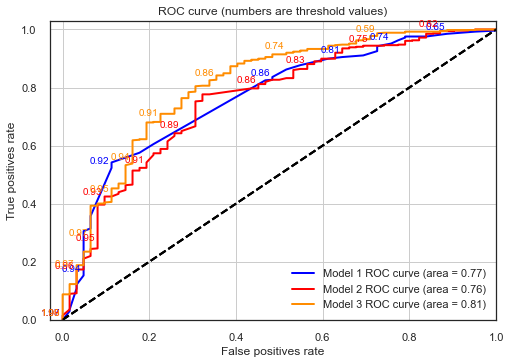

In [27]:
lr_probs_model3 = result_model3.predict(sm.add_constant(testX_model3))

plot_roc(testy_model1, lr_probs_model1, positive_label=1, thresholds_every=5, title="Model 1",c='blue')
plot_roc(testy_model2 , yhat_model2, positive_label=1, thresholds_every=20, title="Model 2",c='red')
plot_roc(testy_model3 , lr_probs_model3, positive_label=1, thresholds_every=20, title="Model 3")

Indeed, **Model 3** appears to be the one with better discrimination power between all models from this section. Now, finally let's look at our classification performance

p(x) threshold value 0.8753
Accuracy: 0.7913188647746243

Precision: 0.9577777777777777
Recall: 0.8026070763500931

Precision Minority Label: 0.28859060402684567
Recall Minority Label: 0.6935483870967742
F-score Model 3: 0.8733535967578521


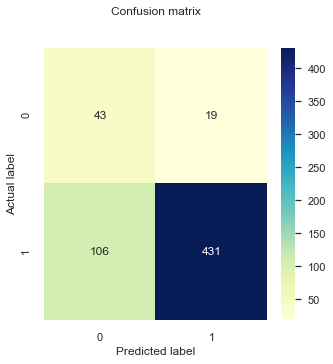

In [28]:
# performing predictions on the test datdaset
threshold_model3 = find_optimal_threshold(testy_model3, yhat_model3)
print ('p(x) threshold value', round(threshold_model3,4))

pred_y_model3 =  [1 if x > threshold_model3 else 0 for x in yhat_model3]


cnf_matrix_model3  = metrics.confusion_matrix(testy_model2,pred_y_model3)

fig, ax = plt.subplots(1,1, figsize = (5,5))
plt_cnf_mat(cnf_matrix_model3 , ax)


print("Accuracy:",metrics.accuracy_score(testy_model3 , pred_y_model3 ))

print()
print("Precision:",metrics.precision_score(testy_model3 , pred_y_model3 ))
print("Recall:",metrics.recall_score(testy_model3 , pred_y_model3 )) 


print ()
testy_model3_minority = abs(testy_model3 - 1)
pred_y_model3_minority = abs(np.array(pred_y_model3) -1)

print("Precision Minority Label:",metrics.precision_score(testy_model3_minority, pred_y_model3_minority))
print("Recall Minority Label:",metrics.recall_score(testy_model3_minority, pred_y_model3_minority)) 

print ('F-score Model 3:', metrics.f1_score(testy_model3 , pred_y_model3))

All of our metrics have improved with respect to **Model 2**!

### Going back to our research question

Up to now we have been exploring different models and attempting to contrast and compare them using different metrics following a typical machine learning approach. However, we need to sit back and think about our research question what exactly we are trying to measure:

> We want to investigate the contribution of material, occupational, and psychosocial factors on the self reported health (SRH) across different European countries. We will use SRH information collected by the Wave 2 and 3 of the EQLTS survey, aware that they offer only a partial representation of European populations and that SRH is per-se a highly subjective indicator, difficult to compare across countries. 

Our goal here is not necessarily to accurately classify between the two classes but to measure the level of contribution that these predictors have in our model (hence improving the discrimination power of the model and therefore contributing to accurately classifying between the classes). Some of the metrics we have been using in this section (log-likelihood and AUC) can definetly help us measure this contributions.

For example, in **Model 3** just adding the mental wellbeing predictor into the model significantly improved the discrimination power of the model for all of our different metrics, therefore we could hint that the self reported mental wellbeing has a sizable contribution on the self reported health for the UK. 

```{admonition} Likelihood ratio
Up to now we have been comparing the log-likehoods between our different models. The reason we can do this is because these are **nested models** meaning that one model is a special case of the other (e.g Model 1 contains a subset of the predictors of Model 2, and equivalent for Model 2 and 3). We haven't been explicit about this but what we are going is equivalent to a likelihood ratio test, which is a statistical test to determine if one (more complex) model fits the data significantly better than the other. The Likelihood (L) ratio is based on the statistic:

$\lambda = -2 ln \left(\frac{{L}(ModelA)}{{L}(ModelB)}\right)= 2 \left(log{L}(ModelA) - log{L}(ModelB)\right)$

In the null model scenario (in this case that Model B is not better at fitting the data than Model A), the test statistic follows a ${\chi}^2$ distribution with degrees of freedom, k, equal to the difference in the number of parameters between the two models being fitted.  This is known as [Wilk’s theorem](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-9/issue-1/The-Large-Sample-Distribution-of-the-Likelihood-Ratio-for-Testing/10.1214/aoms/1177732360.full).

Knowing this, we can calculate a p-value using the chi-square test using the cumulative density function of the ${\chi}^2$ distribution :

$p=1-cdf\chi^{2}(\lambda,k)$  

```



So, lets calculate the likelihood ratio of Model 3 against Model 2. Given that we have both log-likelihoods, calculating the test statistic is simple:



In [29]:
LR = 2 *(result_model3.llf - result_model2.llf)

print (LR)

116.19498936673153


So our likelihood ratio test statistic is 116.2, with one degree of freedom, given that we only added one extra variable to Model 3. We can now calculate the p-value:

In [38]:
degrees_of_freedom = 1
p = 1 - stats.chi2.cdf(LR,1)

print (p)

0.0


Such a small p-value confirms what we already know that Model 3 fits significantly better the data than the Model 2.

### Model 4: A simpler model with equivalent discrimination power

During this section we have slowly built the complexity of the model in order to improve the discrimination power of it. However, we don't necesarily always want a very complex model, given that this can lead to problems with model explanability and **overfitting**. Furthermore, in this case we can to assess the contribution of individual SE factors into the self reported health, and we don't want to use variables that are not completely orthogonal to each other. However, we don't want to lose model performance by reducing the amount of information we feed into it.

Everything we have learn about our data by slowly increasing the complexity of the models hint us that is possible to build a simpler model that is equivalent in discrimination power. Let's see what happens if we remove the variables from number of children and accomodation problems that we know are related to deprivation and the age.

In [31]:
X = df11_model[['AgeCategory','DeprIndex','ISCED',"MentalWellbeingIndex"]]

y = df11_model.SRH_binary.values

trainX_model4, testX_model4, trainy_model4, testy_model4 = train_test_split(X, y, test_size=0.3, random_state=2)
trainX_const_model4 = sm.add_constant(trainX_model4) #add constant for intercept
logit_model4 = sm.Logit(trainy_model4, trainX_const_model4) #Create model instance
result_model4 = logit_model4.fit() #Fit model

print (result_model4.summary())

Optimization terminated successfully.
         Current function value: 0.278443
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1395
Model:                          Logit   Df Residuals:                     1390
Method:                           MLE   Df Model:                            4
Date:                Fri, 29 Oct 2021   Pseudo R-squ.:                  0.2151
Time:                        16:31:56   Log-Likelihood:                -388.43
converged:                       True   LL-Null:                       -494.88
Covariance Type:            nonrobust   LLR p-value:                 6.302e-45
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8293      0.549      1.510      0.131      -0.247       1.906

/anaconda3/envs/rds-course/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Only 4 units of **log-likehood** are lost by droping this variables. And the **Pseudo R-squ.** is equivalent.

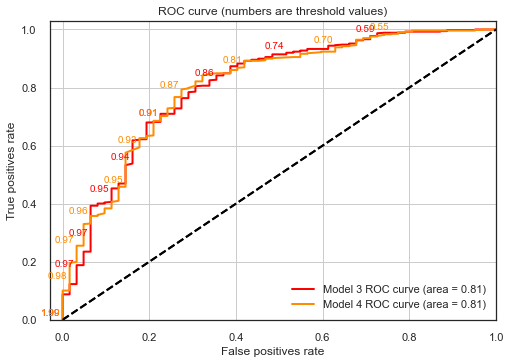

In [32]:
lr_probs_model4 = result_model4.predict(sm.add_constant(testX_model4))

plot_roc(testy_model3 , lr_probs_model3, positive_label=1, thresholds_every=20, title="Model 3",c='red')
plot_roc(testy_model4 , lr_probs_model4, positive_label=1, thresholds_every=20, title="Model 4")

Our **ROC** curves are equivalent!

TODO:

- Talk about parsimony of models

### References and Further Reading

[Blog post: Testing if one model fits the data significantly better than another model](http://sherrytowers.com/2019/03/18/determining-which-model-fits-the-data-significantly-better/)

[Blog post: How are the likelihood ratio, wald and lagrange multiplier test different and/or similar](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-are-the-likelihood-ratio-wald-and-lagrange-multiplier-score-tests-different-andor-similar/)